# Poverty Prediction: From Visualization to Model Stacking
**By Johnny Yiu**
<a href="https://www.worldbank.org/en/news/video/2018/10/17/new-ways-of-looking-at-poverty"><img src="https://i.imgur.com/jIVQ94c.png" title="Source: World Bank" /></a>

## Overview
The motivation of creating this notebook is a data science competition hosted by **Microsoft** and **DrivenData**, which is a part of the Capstone project of the **Microsoft Professional Certificate in Data Science** and also my very first competition related to machine learning. By the end of the competition, I was at the **top 4%** on the leaderboard, and I am happy to share with you my approach, especially to those who are just beginning their journey on data science.

<a href="https://datasciencecapstone.org/competitions/15/predicting-poverty/leaderboard/"><img src="https://i.imgur.com/Yo4Oeya.png" title="Leaderboard" /></a>

<a href="https://datasciencecapstone.org/competitions/15/predicting-poverty/leaderboard/"><img src="https://i.imgur.com/ItktCZr.png" title="Best Score" /></a>

Participants are to predict the probability that individuals across 7 different countries live below the poverty line at the $2.50/day threshold, given other socioeconomic indicators. The probability of being in poverty was calculated using the **Poverty Probability Index (PPI)**, which estimates an individual's poverty status using 10 questions about a household’s characteristics and asset ownership. The remaining data comes from the **Financial Inclusion Insights** household surveys conducted by InterMedia.

<a href="https://www.povertyindex.org"><img src="https://www.povertyindex.org/sites/default/files/PPI-logo-RGB-header-image.png" title="PPI" /></a>
<a href="http://finclusion.org"><img src="https://i.imgur.com/jjPjT06.png" title="Fii" /></a>

The dataset was retrieved from datasciencecapstone.org and contains the PPI along with 58 features of 12,600 individuals across 7 different countries.

**Information on the competition and the data:**
https://datasciencecapstone.org/competitions/15/predicting-poverty/page/47/

**The model stacking approach here is inspired by Serigne, make sure to check it out at:**
[Serigne's Stacked Regressions Notebook](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard).

# Data Pre-processing
We start by first preparing the data into suitable formats for analysis.


The required packages and data sets are loaded. I have merged the features and labels data sets into one dataset.

In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
from sklearn import feature_selection as fs
import sklearn.decomposition as skde
import sklearn.metrics as sklm
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
from sklearn.linear_model import ElasticNet, Lasso,  Ridge, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score
import lightgbm as lgb
import xgboost as xgb

%matplotlib inline

In [2]:
df_features = pd.read_csv('../input/train_values_wJZrCmI.csv')
df_labels = pd.read_csv('../input/train_labels.csv')
df = df_features.merge(df_labels, on='row_id')

df.shape

(12600, 60)

### Drop duplicates
No duplicates detected

In [3]:
df = df.drop_duplicates(keep = 'last')
df = df.drop_duplicates(subset = 'row_id', keep = 'last')

df.shape

(12600, 60)

### Treat missing values
Dropping columns with mostly missing values:

In [4]:
print(df.isnull().sum())

df.drop('bank_interest_rate', axis = 1, inplace = True)
df.drop('mm_interest_rate', axis = 1, inplace = True)
df.drop('mfi_interest_rate', axis = 1, inplace = True)
df.drop('other_fsp_interest_rate', axis = 1, inplace = True)

df.isnull().sum()

row_id                                       0
country                                      0
is_urban                                     0
age                                          0
female                                       0
married                                      0
religion                                     0
relationship_to_hh_head                      0
education_level                            236
literacy                                     0
can_add                                      0
can_divide                                   0
can_calc_percents                            0
can_calc_compounding                         0
employed_last_year                           0
employment_category_last_year                0
employment_type_last_year                    0
share_hh_income_provided                   305
income_ag_livestock_last_year                0
income_friends_family_last_year              0
income_government_last_year                  0
income_own_bu

row_id                                     0
country                                    0
is_urban                                   0
age                                        0
female                                     0
married                                    0
religion                                   0
relationship_to_hh_head                    0
education_level                          236
literacy                                   0
can_add                                    0
can_divide                                 0
can_calc_percents                          0
can_calc_compounding                       0
employed_last_year                         0
employment_category_last_year              0
employment_type_last_year                  0
share_hh_income_provided                 305
income_ag_livestock_last_year              0
income_friends_family_last_year            0
income_government_last_year                0
income_own_business_last_year              0
income_pri

#### Replace missing values   
Assigning missing values to a new category for both `education_level` and `share_hh_income_provided` gives with best R-squared for our regression model.

In [5]:
# df['education_level'].fillna(df['education_level'].median(), inplace=True)
# df['share_hh_income_provided'].fillna(df['share_hh_income_provided'].median(), inplace=True)

# df.dropna(subset=['education_level'], inplace=True)
# df.dropna(subset=['share_hh_income_provided'], inplace=True)

df['education_level'].fillna(4, inplace=True)
df['share_hh_income_provided'].fillna(0, inplace=True)

df.isnull().sum()
# print(df.loc[df['education_level'] == 'Unknown'])

row_id                                   0
country                                  0
is_urban                                 0
age                                      0
female                                   0
married                                  0
religion                                 0
relationship_to_hh_head                  0
education_level                          0
literacy                                 0
can_add                                  0
can_divide                               0
can_calc_percents                        0
can_calc_compounding                     0
employed_last_year                       0
employment_category_last_year            0
employment_type_last_year                0
share_hh_income_provided                 0
income_ag_livestock_last_year            0
income_friends_family_last_year          0
income_government_last_year              0
income_own_business_last_year            0
income_private_sector_last_year          0
income_publ

In [6]:
df.dtypes

row_id                                     int64
country                                   object
is_urban                                    bool
age                                      float64
female                                      bool
married                                     bool
religion                                  object
relationship_to_hh_head                   object
education_level                          float64
literacy                                    bool
can_add                                     bool
can_divide                                  bool
can_calc_percents                           bool
can_calc_compounding                        bool
employed_last_year                          bool
employment_category_last_year             object
employment_type_last_year                 object
share_hh_income_provided                 float64
income_ag_livestock_last_year               bool
income_friends_family_last_year             bool
income_government_la

Replacing true/false with 1/0 for categorical features isn't necessary for the new OneHotEncoder, as it takes strings as arguments.



In [7]:
# def replace_boolean(data):
#     for col in data:
#         data[col].replace(True, 1, inplace=True)
#         data[col].replace(False, 0, inplace=True)
        
# replace_boolean(df)
# df.dtypes

Removing outliers decreased our R-squared.

In [8]:
df.describe()

,row_id,age,education_level,share_hh_income_provided,num_times_borrowed_last_year,borrowing_recency,num_shocks_last_year,avg_shock_strength_last_year,phone_technology,phone_ownership,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year,poverty_probability
count,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000,12600.00000,12600.000000,12600.000000,12600.000000,12600.000000,12600.000000
mean,6299.500000,36.280714,1.366508,2.818254,0.657698,0.866429,1.100159,2.112765,1.20873,1.468254,0.714127,0.188968,1.559683,0.611272
std,3637.451031,15.145945,0.967914,1.607729,0.924598,0.960866,1.190072,2.019239,1.09306,0.776638,0.805878,0.473696,2.043831,0.291476
min,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3149.750000,25.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.394000
50%,6299.500000,33.000000,1.000000,2.000000,0.000000,0.000000,1.000000,2.000000,1.00000,2.000000,1.000000,0.000000,1.000000,0.633000
75%,9449.250000,45.000000,2.000000,5.000000,1.000000,2.000000,2.000000,4.000000,2.00000,2.000000,1.000000,0.000000,3.000000,0.879000
max,12599.000000,115.000000,4.000000,5.000000,3.000000,2.000000,5.000000,5.000000,3.00000,2.000000,6.000000,4.000000,10.000000,1.000000


In [9]:
# df = df[df.poverty_probability > 0]
# df = df[df.poverty_probability < 1]
# df = df[df.num_financial_activities_last_year < 10]
df.shape

(12600, 56)

# Exploratory data analysis
### Exploring the label

Square transformation on the label produces a less skewed distribution, but decreases our R-squared. Other transformations did not make the distribution more normal.

In [10]:
# df['poverty_probability'].describe().to_csv('D:\\Users\\user\\Desktop\\MPP DS Cert\DAT102x - Microsoft Professional Capstone Data Science\\label_summary.csv')

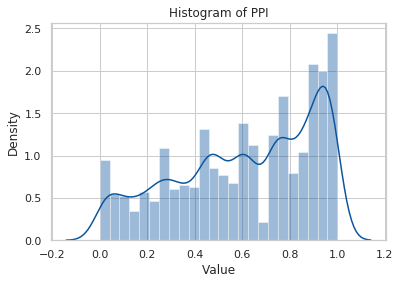

In [11]:
def hist_plot(vals, lab):
    ## Distribution plot of values
    sns.set(style="whitegrid", palette='Blues_r')
    sns.distplot(vals)
    plt.title('Histogram of ' + lab)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()
    
sns.set_style("whitegrid")
hist_plot(df['poverty_probability'], 'PPI')

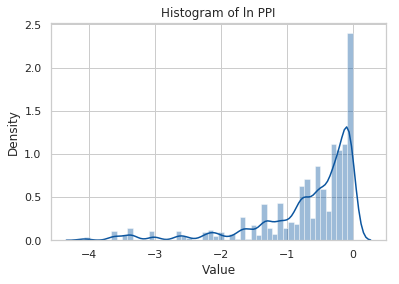

In [12]:
#FUNCTION FOR returning 0 for ln(0)
from numpy import errstate,isneginf
a = df['poverty_probability']
with errstate(divide='ignore'):
    res = np.log(a)
res[isneginf(res)]=0
hist_plot(res, 'ln PPI')

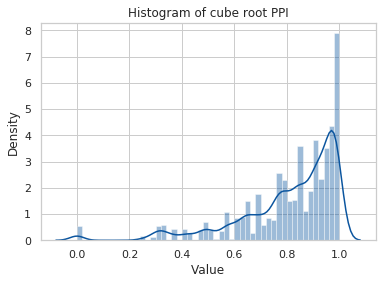

In [13]:
#CUBE ROOT LABELS
df['cbrt_poverty_probability'] = np.cbrt(df['poverty_probability'])
hist_plot(df['cbrt_poverty_probability'], 'cube root PPI')

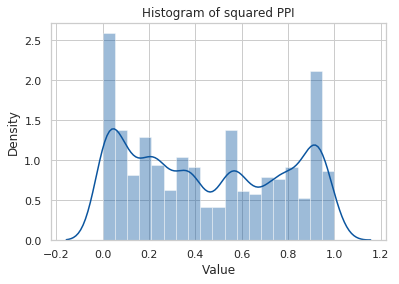

In [14]:
#SQUARE LABELS
df['squared_poverty_probability'] = np.square(df['poverty_probability'])
hist_plot(df['squared_poverty_probability'], 'squared PPI')

### Exploring features

In [15]:
list(df.columns.values)

['row_id',
 'country',
 'is_urban',
 'age',
 'female',
 'married',
 'religion',
 'relationship_to_hh_head',
 'education_level',
 'literacy',
 'can_add',
 'can_divide',
 'can_calc_percents',
 'can_calc_compounding',
 'employed_last_year',
 'employment_category_last_year',
 'employment_type_last_year',
 'share_hh_income_provided',
 'income_ag_livestock_last_year',
 'income_friends_family_last_year',
 'income_government_last_year',
 'income_own_business_last_year',
 'income_private_sector_last_year',
 'income_public_sector_last_year',
 'num_times_borrowed_last_year',
 'borrowing_recency',
 'formal_savings',
 'informal_savings',
 'cash_property_savings',
 'has_insurance',
 'has_investment',
 'num_shocks_last_year',
 'avg_shock_strength_last_year',
 'borrowed_for_emergency_last_year',
 'borrowed_for_daily_expenses_last_year',
 'borrowed_for_home_or_biz_last_year',
 'phone_technology',
 'can_call',
 'can_text',
 'can_use_internet',
 'can_make_transaction',
 'phone_ownership',
 'advanced_phon

The feautre age_group is created from age:

In [16]:
def create_age_group(data):
    age_conditions = [
    (data['age'] < 30 ),
    (data['age'] >= 30) & (data['age'] < 45),
    (data['age'] >= 45) & (data['age'] < 60),
    (data['age'] >= 60)
    ]
    age_choices = ['Under 30', '30 to 44', '45 to 59', '60 or Over']
    data['age_group'] = np.select(age_conditions, age_choices)

create_age_group(df)

#### Exploring categorical features
Counting unique values for categorical features - we see that some features, like religion, have values with very little data. Feature engineering will be performed to solve the problem.

Note that some discrete numerical features are treated as categorical features.

In [17]:
def count_unique(df, cols):
    for col in cols:
        print('\n' + 'For column ' + col)
        print(df[col].value_counts())

cat_cols = ['age_group','country','is_urban','female','married','religion','relationship_to_hh_head',
 'education_level','literacy','can_add','can_divide','can_calc_percents','can_calc_compounding',
 'employed_last_year','employment_category_last_year','employment_type_last_year',
 'income_ag_livestock_last_year','income_friends_family_last_year','income_government_last_year',
 'income_own_business_last_year','income_private_sector_last_year','income_public_sector_last_year',
 'borrowing_recency','formal_savings','informal_savings','cash_property_savings',
 'has_insurance','has_investment','borrowed_for_emergency_last_year','borrowed_for_daily_expenses_last_year',
 'borrowed_for_home_or_biz_last_year','phone_technology','can_call','can_text','can_use_internet',
 'can_make_transaction','phone_ownership','advanced_phone_use','reg_bank_acct',
 'reg_mm_acct','reg_formal_nbfi_account','financially_included','active_bank_user',
 'active_mm_user','active_formal_nbfi_user','active_informal_nbfi_user','nonreg_active_mm_user', 'share_hh_income_provided', 
'num_times_borrowed_last_year','num_shocks_last_year','num_formal_institutions_last_year',
            'num_informal_institutions_last_year']

count_unique(df, cat_cols)
df.shape


For column age_group
Under 30      4952
30 to 44      4236
45 to 59      2183
60 or Over    1229
Name: age_group, dtype: int64

For column country
J    1843
D    1829
I    1812
G    1805
A    1773
C    1769
F    1769
Name: country, dtype: int64

For column is_urban
False    8460
True     4140
Name: is_urban, dtype: int64

For column female
True     7028
False    5572
Name: female, dtype: int64

For column married
True     8172
False    4428
Name: married, dtype: int64

For column religion
Q    5469
X    5297
P    1694
O      85
N      55
Name: religion, dtype: int64

For column relationship_to_hh_head
Head              5229
Spouse            4162
Son/Daughter      2177
Father/Mother      415
Other              321
Sister/Brother     278
Unknown             18
Name: relationship_to_hh_head, dtype: int64

For column education_level
1.0    4550
2.0    4083
0.0    2545
3.0    1186
4.0     236
Name: education_level, dtype: int64

For column literacy
True     7736
False    4864
Name: litera

(12600, 59)

Creating violin plots for all categorical features against our label PPI - only some features have values that are distinctively different in PPI distributions.

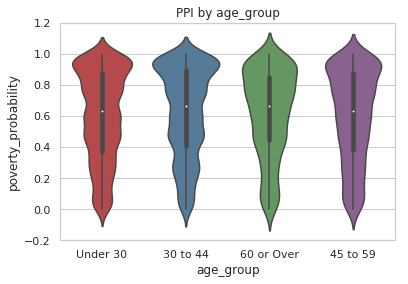

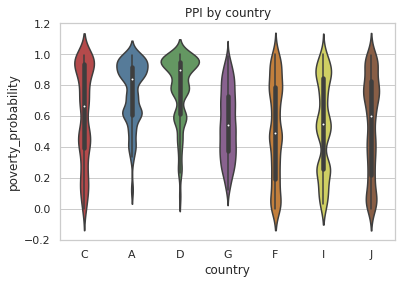

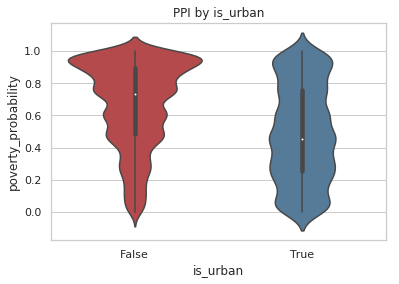

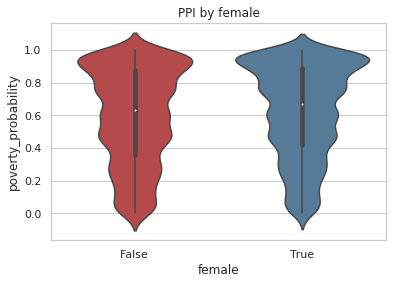

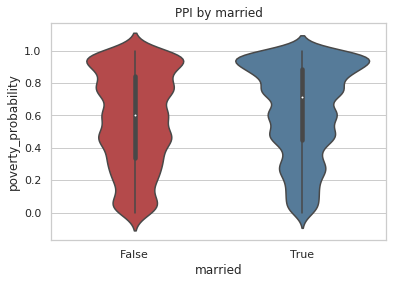

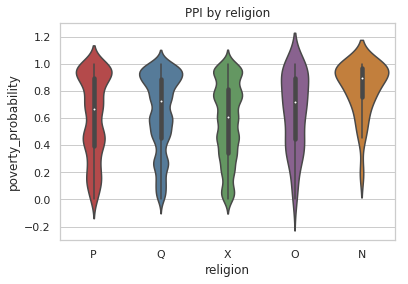

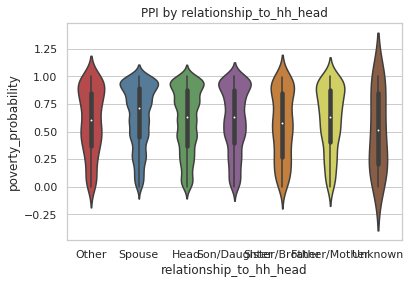

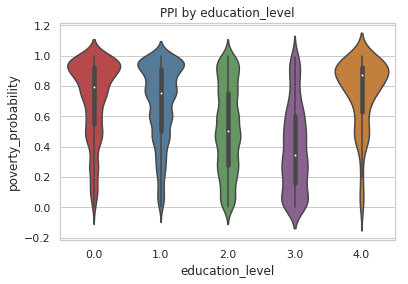

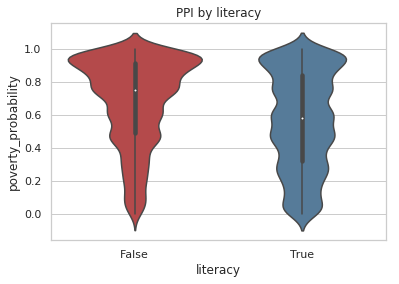

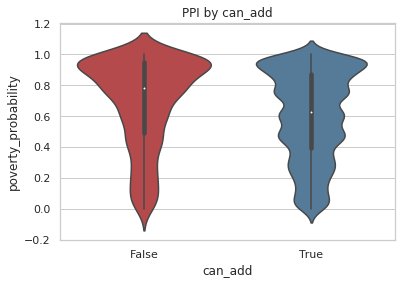

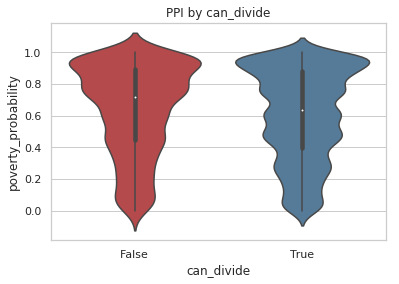

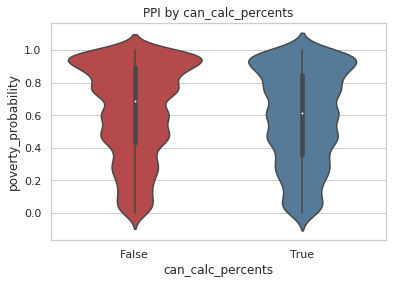

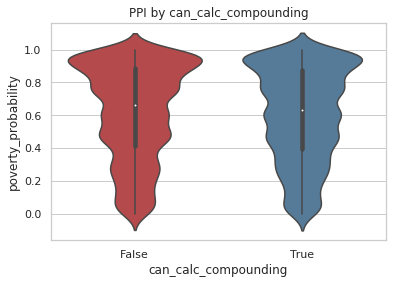

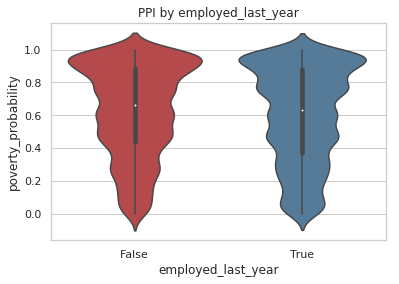

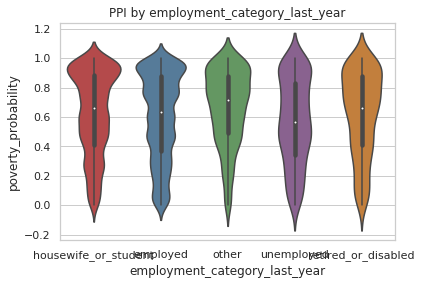

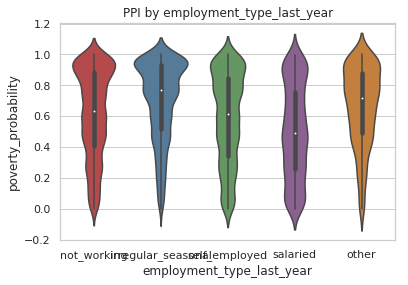

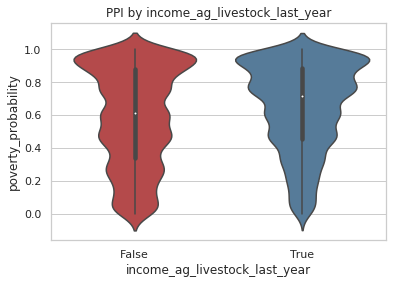

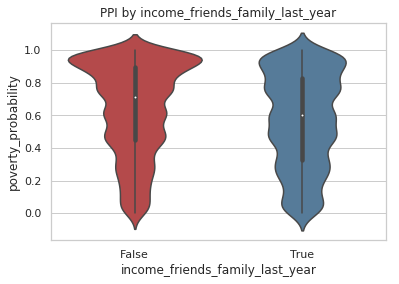

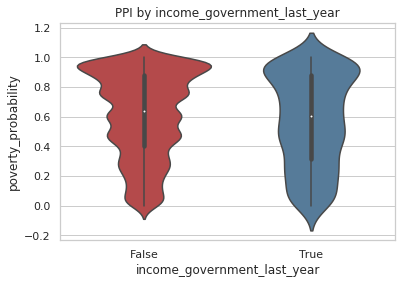

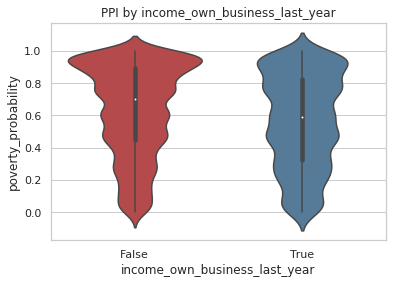

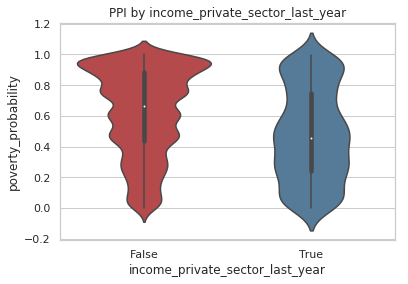

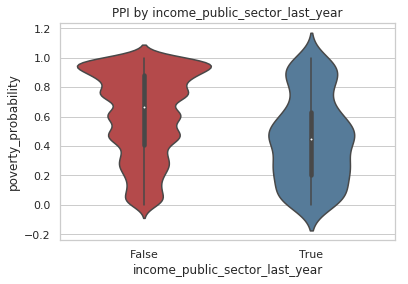

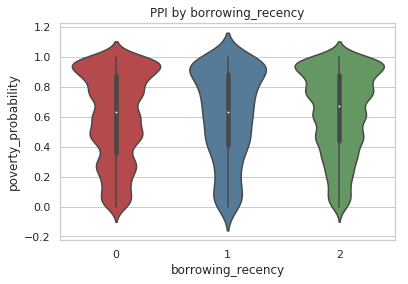

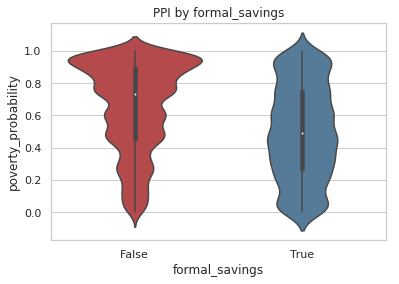

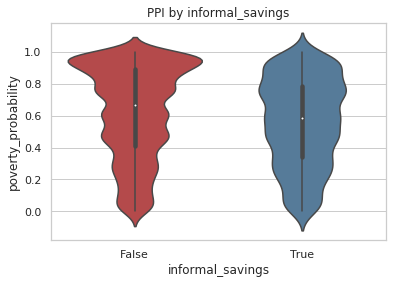

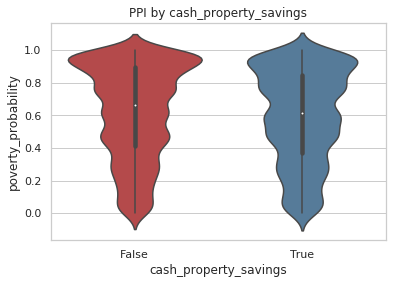

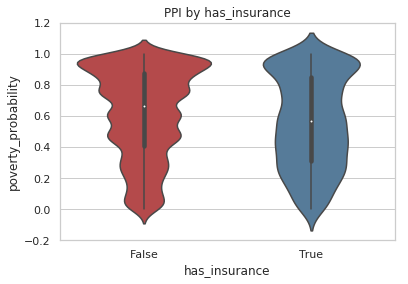

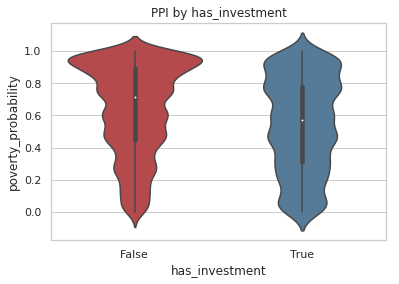

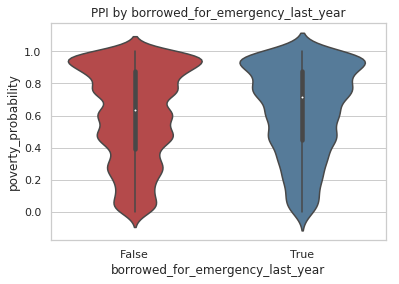

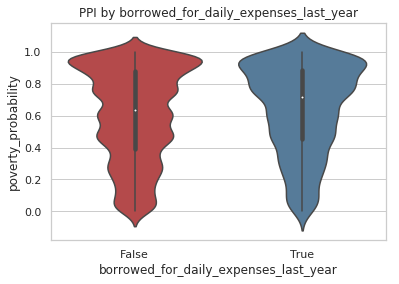

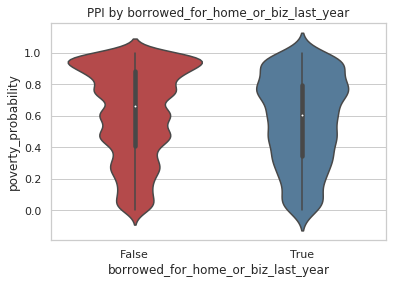

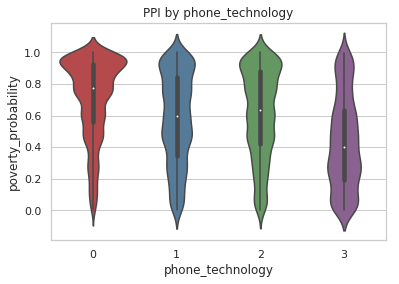

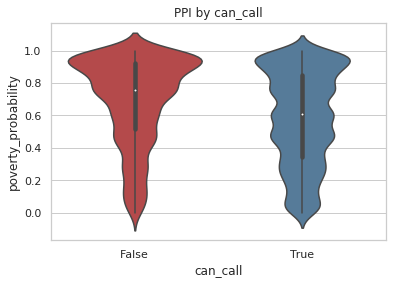

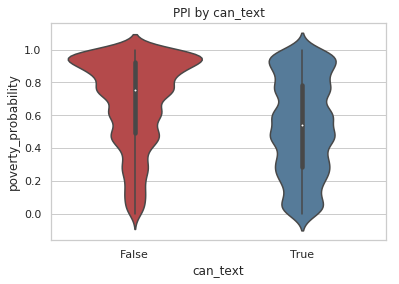

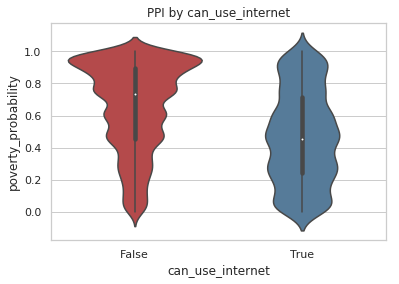

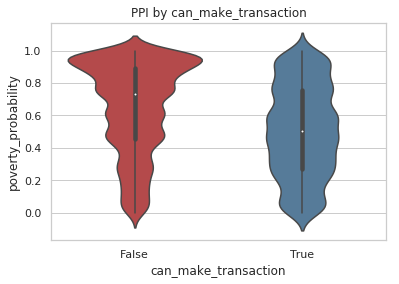

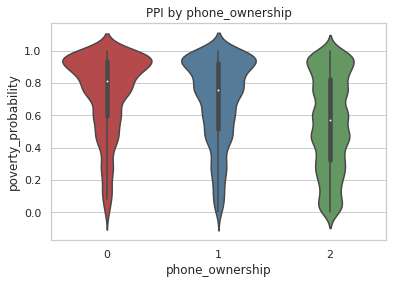

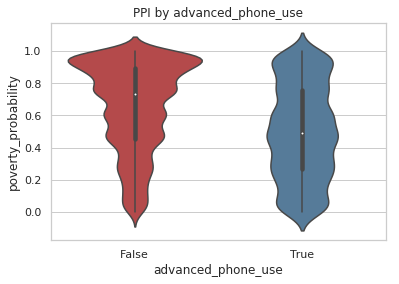

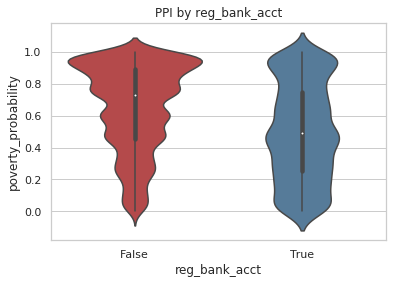

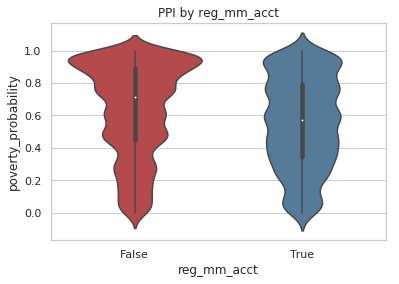

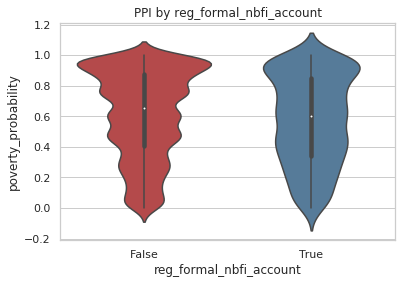

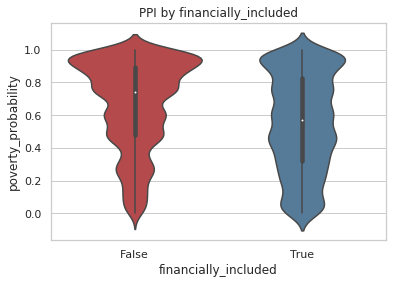

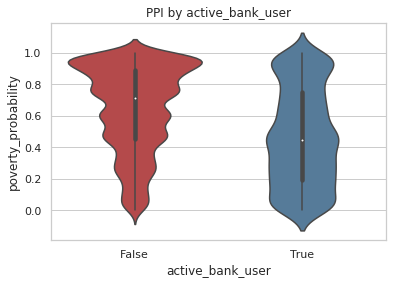

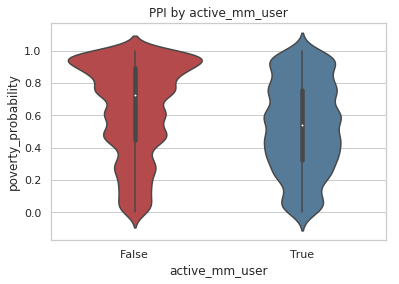

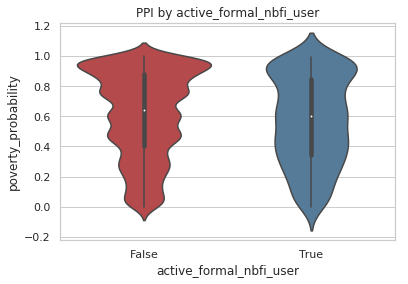

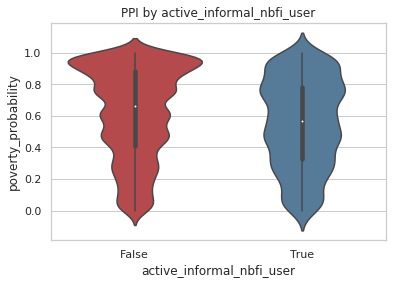

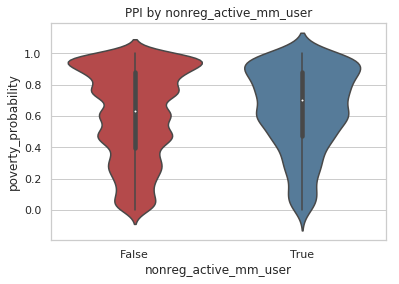

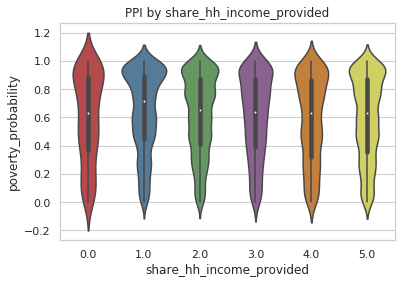

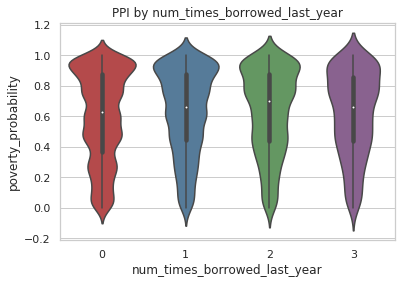

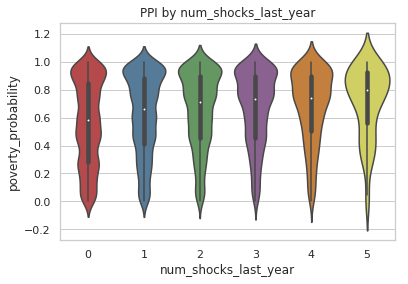

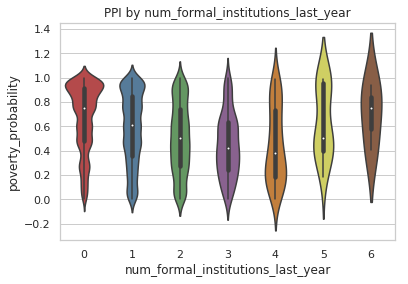

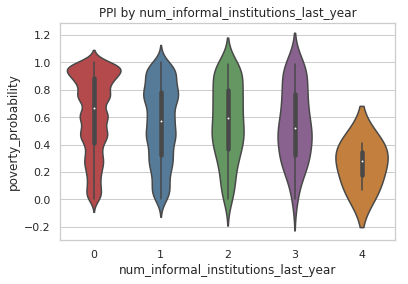

In [18]:
def plot_violin(df, cols, col_y, title):
    for col in cols:
        sns.set(style="whitegrid")
        sns.set_palette("Set1", n_colors=7, desat=.7)
        sns.violinplot(col, col_y, data=df)
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel(col_y)# Set text for y axis
        plt.title(title + ' by ' + col)
        plt.show()
        
plot_violin(df, cat_cols, 'poverty_probability', 'PPI')    

#### Explore numeric features
Creating combined kernel density estimation and histogram plots for all numeric features:

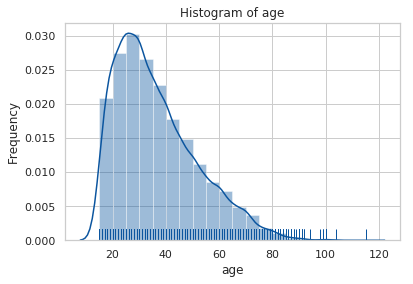

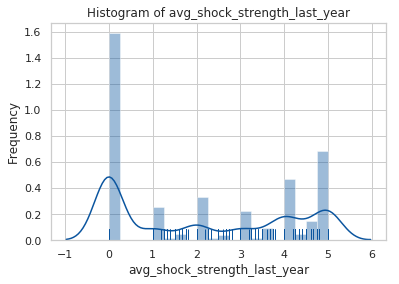

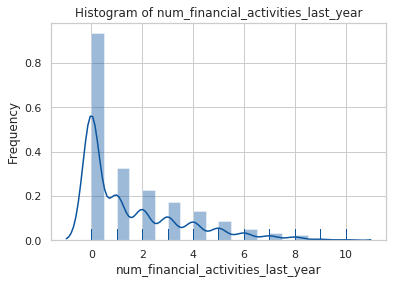

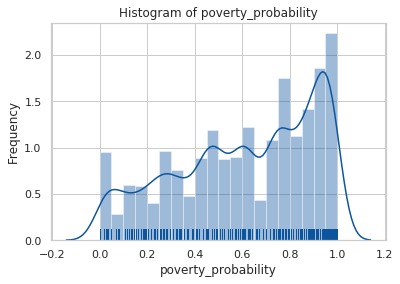

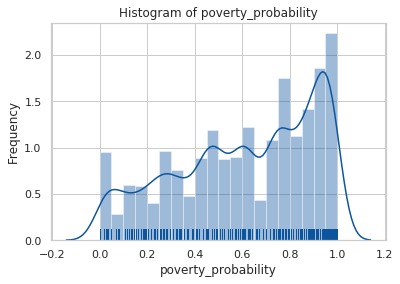

In [19]:
num_cols = ['age', 'avg_shock_strength_last_year', 
            'num_financial_activities_last_year', 
            'poverty_probability', 'poverty_probability'] 

def plot_density_hist(df, cols, bins = 10, hist = False):
    for col in cols:
        sns.set(style="whitegrid", palette='Blues_r')
        sns.distplot(df[col], bins = bins, rug=True, hist = hist)
        plt.title('Histogram of ' + col) # Give the plot a main title
        plt.xlabel(col) # Set text for the x axis
        plt.ylabel('Frequency')# Set text for y axis
        plt.show()
        
plot_density_hist(df, num_cols, bins = 20, hist = True)

A pairplot and a correlation matrix of numeric features is created - apparent relationships are neither found within numeric features, and between the label and these features.

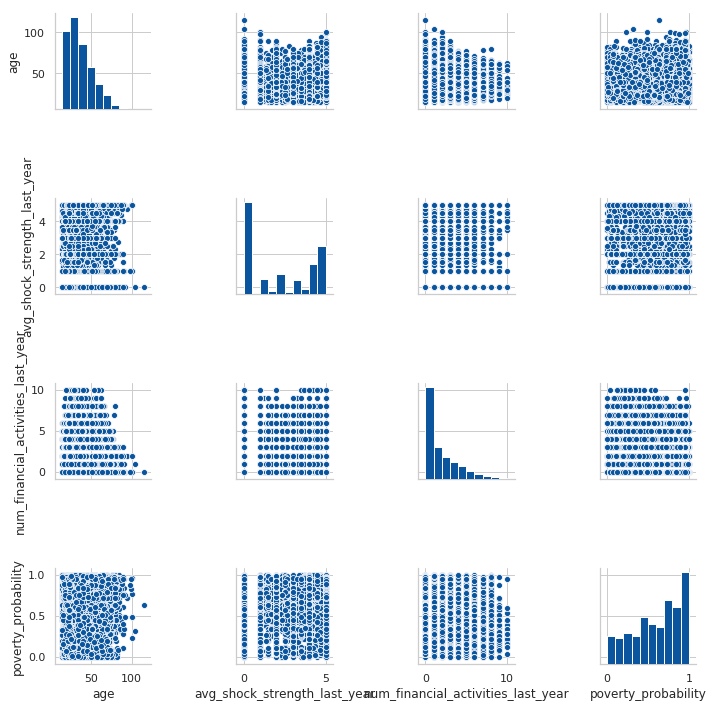

In [20]:
num_cols = ['age', 'avg_shock_strength_last_year', 
            'num_financial_activities_last_year', 'poverty_probability'] 

sns.set(style="whitegrid", palette='Blues_r')
sns.pairplot(df[num_cols])

However, on average, the amount of financial activities seems to decrease with age.

In [21]:
## Compute the correlation matrix
corrs = df[num_cols].corr()

## Create the hierarchical clustering model
dist = sch.distance.pdist(corrs)   # vector of pairwise distances using correlations
linkage = sch.linkage(dist, method='complete') # Compute the linkages for the clusters
ind = sch.fcluster(linkage, 0.5*dist.max(), 'distance')  # Apply the clustering algorithm

## Order the columns of the correlaton matrix according to the hierarchy
columns = [corrs.columns.tolist()[i] for i in list((np.argsort(ind)))]  # Order the names for the result
corrs_clustered = corrs.reindex(columns) ## Reindex the columns following the heirarchy 

## Correlation Plot
corrs_clustered.style.background_gradient().set_precision(2)

,age,avg_shock_strength_last_year,num_financial_activities_last_year,poverty_probability
avg_shock_strength_last_year,0.068,1,0.066,0.13
poverty_probability,0.0072,0.13,-0.26,1
age,1,0.068,-0.047,0.0072
num_financial_activities_last_year,-0.047,0.066,1,-0.26


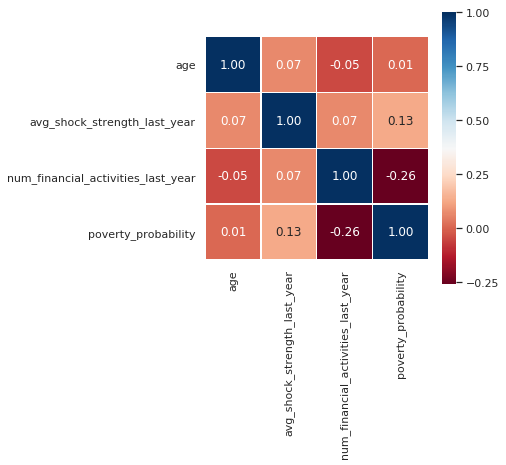

In [22]:
num_corrs = df[num_cols].corr()
f,ax = plt.subplots(figsize=(5, 5))
sns.heatmap(num_corrs, annot=True, square=True, linewidths=.1, fmt= '.2f',ax=ax, 
           cmap="RdBu")
plt.show()

### Feature engineering
#### Aggregate categorical features

The aggregation of categorical features was performed to reduce the number of categories. For discrete variables, rare values are combined to form a range of values. For categorical variables, rare values are combined with common values that share a more similar distribution in PPI.

- Religion O is combined with religion P to form religion O_P, and religion N is combined with religion Q to form religion ‘N_Q’
- The number of shocks of 4 or above are combined to form ‘4_5’
- The number of formal financial institutions used of 3 or above are combined to form ‘3_4_5_6’
- The number of informal financial institutions used of 2 or above are combined to form ‘2_3_4’
- The number of shocks of 4 or above are combined to form ‘4_5’ 
- The category ‘Unknown’ for relationship to the head of the household is combined with ‘Other’

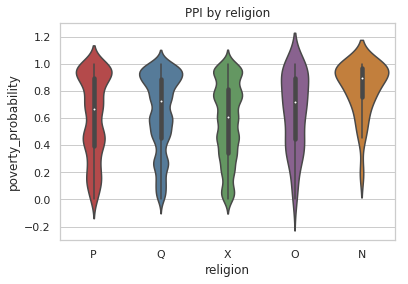

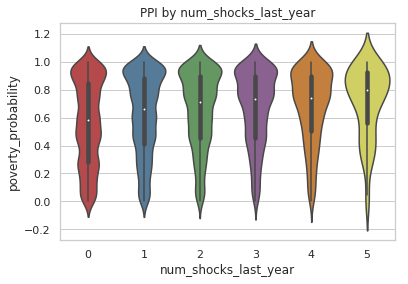

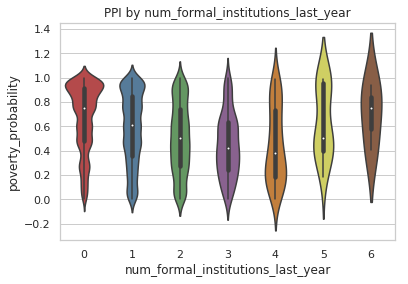

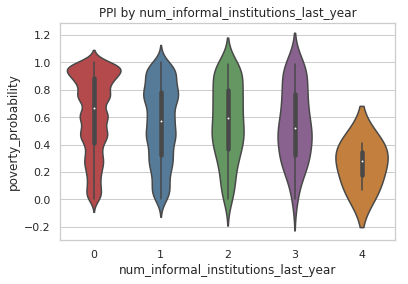

In [23]:
def plot_box_1(df, col, col_y, title):
    sns.set_style("whitegrid")
    sns.set_palette("Set1", n_colors=7, desat=.7)
    sns.boxplot(col, col_y, data=df)
    plt.xlabel(col) # Set text for the x axis
    plt.ylabel(col_y)# Set text for y axis
    plt.title(title + ' by ' + col)
    plt.show()
    
def plot_violin_1(df, col, col_y, title):
    sns.set_style("whitegrid")
    sns.set_palette("Set1", n_colors=7, desat=.7)
#     fig, ax = plt.subplots(figsize=(11,8))
    sns.violinplot(col, col_y, data=df)
    plt.xlabel(col) # Set text for the x axis
    plt.ylabel(col_y)# Set text for y axis
    plt.title(title + ' by ' + col)
    plt.show()

plot_violin_1(df, 'religion', 'poverty_probability', 'PPI')
plot_violin_1(df, 'num_shocks_last_year', 'poverty_probability', 'PPI')
plot_violin_1(df, 'num_formal_institutions_last_year', 'poverty_probability', 'PPI')
plot_violin_1(df, 'num_informal_institutions_last_year', 'poverty_probability', 'PPI')

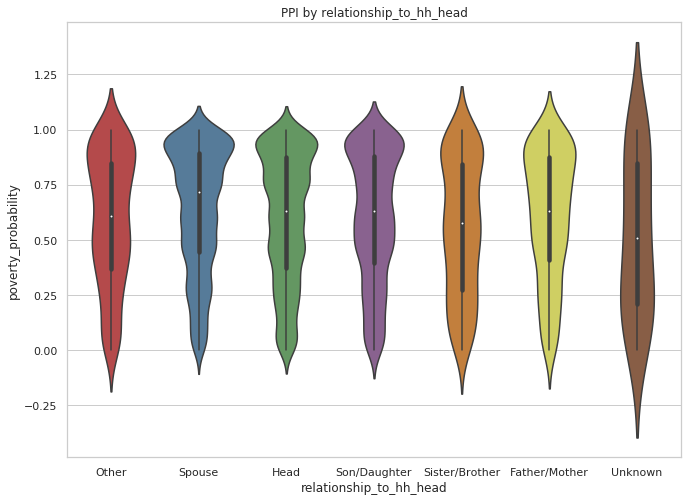

In [24]:
    sns.set_style("whitegrid")
    sns.set_palette("Set1", n_colors=7, desat=.7)
    fig, ax = plt.subplots(figsize=(11,8))
    sns.violinplot('relationship_to_hh_head', 'poverty_probability', data=df) #order=['Under 30', '30 to 44', '45 to 59', '60 or Over']
    plt.xlabel('relationship_to_hh_head') # Set text for the x axis
    plt.ylabel('poverty_probability')# Set text for y axis
    plt.title('PPI' + ' by ' + 'relationship_to_hh_head')
    plt.show()


In [25]:
religion_categories = {'N':'N_Q', 'O':'O_P',
                       'P':'O_P', 'Q':'N_Q','X':'X'}
df['religion'] = [religion_categories[x] for x in df['religion']]
print(df['religion'].value_counts())

#num_shocks_last_year 4_5
num_shocks_last_year_categories = {0:'0', 1:'1', 2:'2',
                       3:'3', 4:'4_5', 5:'4_5'}
df['num_shocks_last_year'] = [num_shocks_last_year_categories[x] for x in df['num_shocks_last_year']]
print(df['num_shocks_last_year'].value_counts())

#num_formal_institutions_last_year 3_or_over
num_formal_institutions_last_year_categories = {0:'0', 1:'1', 2:'2',
                       3:'3_4_5_6', 4:'3_4_5_6', 5:'3_4_5_6', 6:'3_4_5_6'}
df['num_formal_institutions_last_year'] = [num_formal_institutions_last_year_categories[x] for x in df['num_formal_institutions_last_year']]
print(df['num_formal_institutions_last_year'].value_counts())

#num_informal_institutions_last_year 2_or_over
num_informal_institutions_last_year_categories = {0:'0', 1:'1', 2:'2_3_4',
                       3:'2_3_4', 4:'2_3_4'}
df['num_informal_institutions_last_year'] = [num_informal_institutions_last_year_categories[x] for x in df['num_informal_institutions_last_year']]
print(df['num_informal_institutions_last_year'].value_counts())

relationship_to_hh_head_categories = {'Other':'Other', 'Spouse':'Spouse',
                                      'Head':'Head',
                                      'Son/Daughter':'Son/Daughter',
                                      'Sister/Brother':'Sister/Brother',
                                      'Father/Mother': 'Father/Mother',
                                      'Unknown':'Other'}
df['relationship_to_hh_head'] = [relationship_to_hh_head_categories[x] for x in df['relationship_to_hh_head']]
print(df['relationship_to_hh_head'].value_counts())

N_Q    5524
X      5297
O_P    1779
Name: religion, dtype: int64
0      5004
1      3860
2      1942
3      1142
4_5     652
Name: num_shocks_last_year, dtype: int64
0          5802
1          5068
2          1373
3_4_5_6     357
Name: num_formal_institutions_last_year, dtype: int64
0        10583
1         1734
2_3_4      283
Name: num_informal_institutions_last_year, dtype: int64
Head              5229
Spouse            4162
Son/Daughter      2177
Father/Mother      415
Other              339
Sister/Brother     278
Name: relationship_to_hh_head, dtype: int64


Create violin plots for the new features:

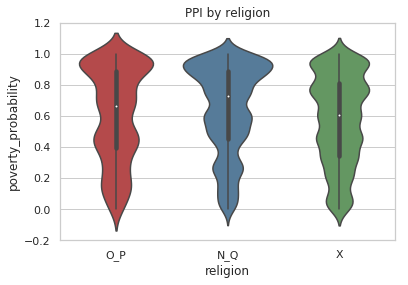

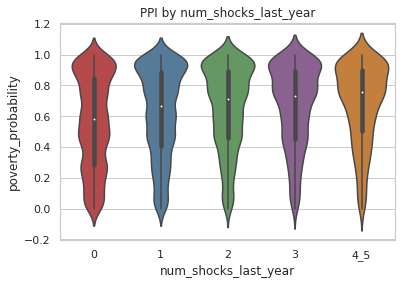

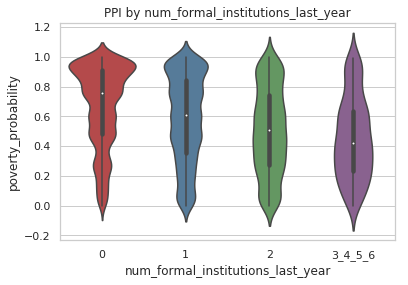

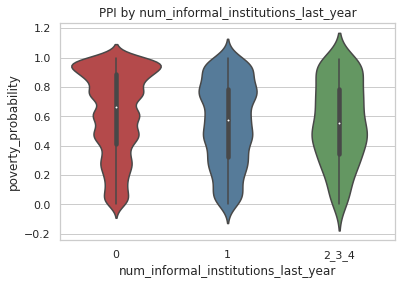

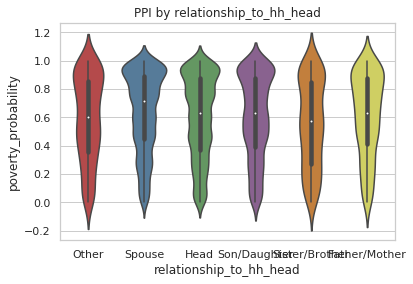

In [26]:
plot_violin_1(df, 'religion', 'poverty_probability', 'PPI') 

plot_violin_1(df, 'num_shocks_last_year', 'poverty_probability', 'PPI') 

plot_violin_1(df, 'num_formal_institutions_last_year', 'poverty_probability', 'PPI') 

plot_violin_1(df, 'num_informal_institutions_last_year', 'poverty_probability', 'PPI') 

plot_violin_1(df, 'relationship_to_hh_head', 'poverty_probability', 'PPI') 

Removing values named 'Unknown' for relationship_to_hh_head was attempted, but it worsened our model.

In [27]:
# df = df[df.relationship_to_hh_head != 'Unknown']
# df.shape

#### Transforming numeric features

Transformed numeric features worsened our model.

In [28]:
# df['ln_age'] = np.log(df['age'])
# hist_plot(df['ln_age'], 'natural log age')

In [29]:
# df['cbrt_num_times_borrowed_last_year'] = np.cbrt(df['num_times_borrowed_last_year'])
# hist_plot(df['cbrt_num_times_borrowed_last_year'], 'cube root num_times_borrowed_last_year')

# Model Matrix Preparation

We are predicting the label `poverty_probability` with both categorical and numeric features. Categorical features are one-hot encoded, and joint back with the numeric features.

In [30]:
Labels = np.array(df['poverty_probability'])
# Labels = np.array(df['poverty_probability'])

In [31]:
def encode_string(cat_features):
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder(categories='auto')
    encoded = ohe.fit_transform(cat_features.values.reshape(-1,1)).toarray()
    pdfn = ohe.get_feature_names()
    print(pdfn)
    return encoded

features_cat_cols = ['country','is_urban','female','married','religion','relationship_to_hh_head',
 'education_level','literacy','can_add','can_divide','can_calc_percents','can_calc_compounding',
 'employed_last_year','employment_category_last_year','employment_type_last_year',
 'income_ag_livestock_last_year','income_friends_family_last_year','income_government_last_year',
 'income_own_business_last_year','income_private_sector_last_year','income_public_sector_last_year',
 'borrowing_recency','formal_savings','informal_savings','cash_property_savings',
 'has_insurance','has_investment','borrowed_for_emergency_last_year','borrowed_for_daily_expenses_last_year',
 'borrowed_for_home_or_biz_last_year','phone_technology','can_call','can_text','can_use_internet',
 'can_make_transaction','phone_ownership','advanced_phone_use','reg_bank_acct',
 'reg_mm_acct','reg_formal_nbfi_account','financially_included','active_bank_user',
 'active_mm_user','active_formal_nbfi_user','active_informal_nbfi_user','nonreg_active_mm_user', 'share_hh_income_provided', 
'num_times_borrowed_last_year','num_shocks_last_year','num_formal_institutions_last_year',
            'num_informal_institutions_last_year']

Features = encode_string(df['age_group'])
for col in features_cat_cols:
    temp = encode_string(df[col])
    Features = np.concatenate([Features, temp], axis = 1)
    
print(Features.shape)
print(Features[:2, :])

['x0_30 to 44' 'x0_45 to 59' 'x0_60 or Over' 'x0_Under 30']
['x0_A' 'x0_C' 'x0_D' 'x0_F' 'x0_G' 'x0_I' 'x0_J']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_N_Q' 'x0_O_P' 'x0_X']
['x0_Father/Mother' 'x0_Head' 'x0_Other' 'x0_Sister/Brother'
 'x0_Son/Daughter' 'x0_Spouse']
['x0_0.0' 'x0_1.0' 'x0_2.0' 'x0_3.0' 'x0_4.0']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_employed' 'x0_housewife_or_student' 'x0_other'
 'x0_retired_or_disabled' 'x0_unemployed']
['x0_irregular_seasonal' 'x0_not_working' 'x0_other' 'x0_salaried'
 'x0_self_employed']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_0' 'x0_1' 'x0_2']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False

In [32]:
features_num_cols = ['avg_shock_strength_last_year',
                     'num_financial_activities_last_year']
Features = np.concatenate([Features, np.array(df[features_num_cols])], axis = 1)
print(Features.shape)
print(Features[:2, :])

(12600, 143)
[[0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.
  1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0.
  0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0.
  0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.
  1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0.
  0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]]


### Model selection

#### Eliminate low variance features

We eliminate features with low variance using the scikit-learn `VarianceThreshold` based function. A p = 0.95 was found to optimize the model.

In [33]:
# Features selection
print(Features.shape)

## Define the variance threhold and fit the threshold to the feature array.
sel = fs.VarianceThreshold(threshold=(.95 * (1 - .95)))
Features_reduced = sel.fit_transform(Features)
print(sel.get_support())

## Print the support and shape for the transformed features
print(Features_reduced.shape)

(12600, 143)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True False False
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True False  True  True]
(12600, 132)


### Recursive feature elimination

We used the scikit-learn `RFECV` function to determine which features to retain using a cross validation method, with the ridge regression model:

In [34]:
#Select k best features with Recursive Feature Eliminiation
## Reshape the Label array
Labels = Labels.reshape(Labels.shape[0],)
## Set folds for nested cross validation
nr.seed(562)
feature_folds = ms.KFold(n_splits=10, shuffle = True)
## Define the model
lin_mod_l2 = linear_model.Ridge()
## Perform feature selection by CV with high variance features only
nr.seed(265)
selector = fs.RFECV(estimator = lin_mod_l2, cv = feature_folds,
                      scoring = 'r2')
selector = selector.fit(Features_reduced, Labels)
print(selector.support_)
print(selector.ranking_)

Features_reduced = selector.transform(Features_reduced)
print(Features_reduced.shape)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True False False  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True False False  True False False
 False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True False False  True
  True  True False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False  True  True  True
  True  True  True False False  True  True  True  True  True  True  True
  True False False  True  True  True  True  True  True False False False
  True  True False  True  True  True  True  True  True  True False  True]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1 12  3  1  1  1  1 13  1  1  1  1
  1  1  1  1  1  1  1 14 20  1  5 25 21 22 26 24  1  1  1  1  1  1  1  1
  1  1  1  1  1  2  1  1  1 10  9  1  1  1 19 11  

# Split the Dataset

With the model matrix constructed, we now create randomly sampled training and test data sets in a 8:2 ratio:

In [35]:
nr.seed(265)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 0.2)
x_train = Features_reduced[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = Features_reduced[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

### Rescale numeric features

We use the `StandardScaler` to z-score scale the numeric features.

In [36]:
scaler = preprocessing.StandardScaler().fit(x_train[:,104:])
x_train[:,104:] = scaler.transform(x_train[:,104:])
x_test[:,104:] = scaler.transform(x_test[:,104:])
print(x_train[:2,])

[[ 0.          0.          0.          1.          0.          0.
   0.          1.          0.          0.          0.          0.
   1.          0.          1.          1.          0.          0.
   0.          1.          0.          0.          0.          1.
   0.          1.          0.          1.          0.          0.
   0.          0.          1.          0.          0.          0.
   1.          0.          1.          0.          1.          0.
   1.          1.          0.          0.          0.          1.
   1.          0.          1.          0.          0.          1.
   1.          0.          1.          0.          1.          0.
   0.          0.          1.          0.          0.          1.
   0.          1.          0.          1.          0.          1.
   0.          0.          1.          0.          1.          0.
   1.          1.          0.          0.          1.          0.
   1.          1.          0.          1.          0.          0.
   0.     

# Construct the Regression Models

Different regression models are tested with optimized hyperparameters. We first fit the models with pre-selected parameters to our train data, and fine-tune them recursively. Here we will test Gradient Boosting Regressor, XGboost Regressor and LGB Regressor, the current best-performing algorithms for data science competitions.

In [37]:
GBoost = GradientBoostingRegressor()
model_xgb = xgb.XGBRegressor()
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves = 32,
                              learning_rate=0.01)

### Hyperparameter tuning

Hyperparameters are manually and recursively selected with a grid search, here is an example of finding the optimized value for XGB Regressor's `n_estimators`:

In [38]:
nr.seed(265)
inside = ms.KFold(n_splits=5, shuffle = True)
nr.seed(562)
outside = ms.KFold(n_splits=5, shuffle = True)

nr.seed(2652)
## Define the dictionary for the grid search and the model object to search on
param_grid = {'n_estimators': [2000, 3000]}

## Perform the grid search over the parameters
gsearch = ms.GridSearchCV(estimator = model_lgb, param_grid = param_grid, 
                      cv = inside, # Use the inside folds
                      scoring = 'r2',
                      return_train_score = True)

Fit the cross validated grid search over the data and print the best parameter value:

In [39]:
gsearch.fit(Features_reduced, Labels)
gsearch.best_params_, gsearch.best_score_

({'n_estimators': 2000}, 0.4233935121671292)

Optimized parameters are plugged into the models:

In [40]:
GBoost = GradientBoostingRegressor(n_estimators= 2000, learning_rate=0.01,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=7, min_samples_split=15, 
                                   loss='ls', random_state = 1)

model_xgb = xgb.XGBRegressor(max_depth = 5, min_child_weight = 0, gamma = 0, 
                           subsample = 0.8, colsample_bytree = 0.8, 
                           scale_pos_weight = 1, reg_lambda = 1,
                           learning_rate =0.01, n_estimators=2000, 
                           objective = 'reg:squarederror', seed = 14)

model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves = 32,
                              learning_rate=0.01, n_estimators=2100, 
                              bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.4,
                              min_data_in_leaf = 5,  
                              feature_fraction_seed=3, bagging_seed=2)

### Evaluate models with cross validation
We define a cross validation strategy to evaluate the r-square of our models:

In [41]:
#Validation function
n_folds = 5

def r2_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train)
    r2 = cross_val_score(model, x_train, y_train, scoring="r2", cv = kf)
    return(r2)

In [42]:
score = r2_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.4254 (0.0142)



In [43]:
score = r2_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.4283 (0.0156)



In [44]:
score = r2_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.4314 (0.0168)



# Model Stacking

Here, 2 model stacking approaches are applied - 
1. averaging base models, and 
2. stacking averaged models and adding a meta-model

For more information, read [Serigne's Stacked Regressions Notebook](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard).

### Averaging base models
We build a new class to extend scikit-learn with our model and leverage inheritance:

In [45]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

Averaging XBG and LGB and print out their cross-validation r-square score:

In [46]:
averaged_models = AveragingModels(models = (model_xgb, model_lgb))

# score = r2_cv(averaged_models)
# print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

### Adding a meta-model
Let's create a class for stacking average models:

In [47]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

Stacking GBR on top of the averaged XBG and LGB and print out their cross-validation r-square score:

In [48]:
stacked_averaged_models = StackingAveragedModels(base_models = (model_lgb, model_xgb),
                                                 meta_model = GBoost)

score = r2_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.4162 (0.0186)


In this case, it looks like simply averaging XGB and LGB gives a better score.

We then create a function to evaluate the models' performances on the test data after fitting to the training data.

In [49]:
def rsquare(y, y_pred):
    return r2_score(y, y_pred)

In [50]:
averaged_models.fit(x_train, y_train)
avg_pred = averaged_models.predict(x_test)
print(rsquare(y_test, avg_pred))

0.46783975970948166


In [51]:
stacked_averaged_models.fit(x_train, y_train)
stacked_pred = stacked_averaged_models.predict(x_test)
print(rsquare(y_test, stacked_pred))

0.4601370717094775


In [52]:
GBoost.fit(x_train, y_train)
gb_pred = GBoost.predict(x_test)
print(rsquare(y_test, gb_pred))

0.4612622943533444


In [53]:
model_xgb.fit(x_train, y_train)
xgb_pred = model_xgb.predict(x_test)
print(rsquare(y_test, xgb_pred))

0.4662100394537001


In [54]:
model_lgb.fit(x_train, y_train)
lgb_pred = model_lgb.predict(x_test)
print(rsquare(y_test, lgb_pred))

0.4664891778725009


For meaningful interpretation, predicted scores with negative values are converted to 0, and scores larger than 1 are converted to 1:

In [55]:
avg_pred[avg_pred < 0] = 0
avg_pred[avg_pred > 1] = 1

In [56]:
stacked_pred[stacked_pred < 0] = 0
stacked_pred[stacked_pred > 1] = 1

In [57]:
gb_pred[gb_pred < 0] = 0
gb_pred[gb_pred > 1] = 1

In [58]:
xgb_pred[xgb_pred < 0] = 0
xgb_pred[xgb_pred > 1] = 1

In [59]:
lgb_pred[lgb_pred < 0] = 0
lgb_pred[lgb_pred > 1] = 1

In [60]:
ensemble = avg_pred*0.55 + lgb_pred*0.45
print('R2 score on test data:')
print(rsquare(y_test, ensemble))

R2 score on test data:
0.46760573058078314


# Print metrics and evaluations

The model's performance metrics on the locally splitted test data is printed:

In [61]:
def print_metrics(y_true, y_predicted, n_parameters):
    ## First compute R^2 and the adjusted R^2
    r2 = sklm.r2_score(y_true, y_predicted)
    r2_adj = r2 - (n_parameters - 1)/(y_true.shape[0] - n_parameters) * (1 - r2)
    
    ## Print the usual metrics and the R^2 values
    print('Mean Square Error      = ' + str(sklm.mean_squared_error(y_true, y_predicted)))
    print('Root Mean Square Error = ' + str(math.sqrt(sklm.mean_squared_error(y_true, y_predicted))))
    print('Mean Absolute Error    = ' + str(sklm.mean_absolute_error(y_true, y_predicted)))
    print('Median Absolute Error  = ' + str(sklm.median_absolute_error(y_true, y_predicted)))
    print('R^2                    = ' + str(r2))
    print('Adjusted R^2           = ' + str(r2_adj))
   
print_metrics(y_test, lgb_pred, 105)    

Mean Square Error      = 0.0469043142800619
Root Mean Square Error = 0.21657403879519332
Mean Absolute Error    = 0.17435000074888973
Median Absolute Error  = 0.14728328810097574
R^2                    = 0.4664891778725009
Adjusted R^2           = 0.4435139706256024


A feature importance plot is created find out what are the top features, here a sample plot for XGB regressor is printed:

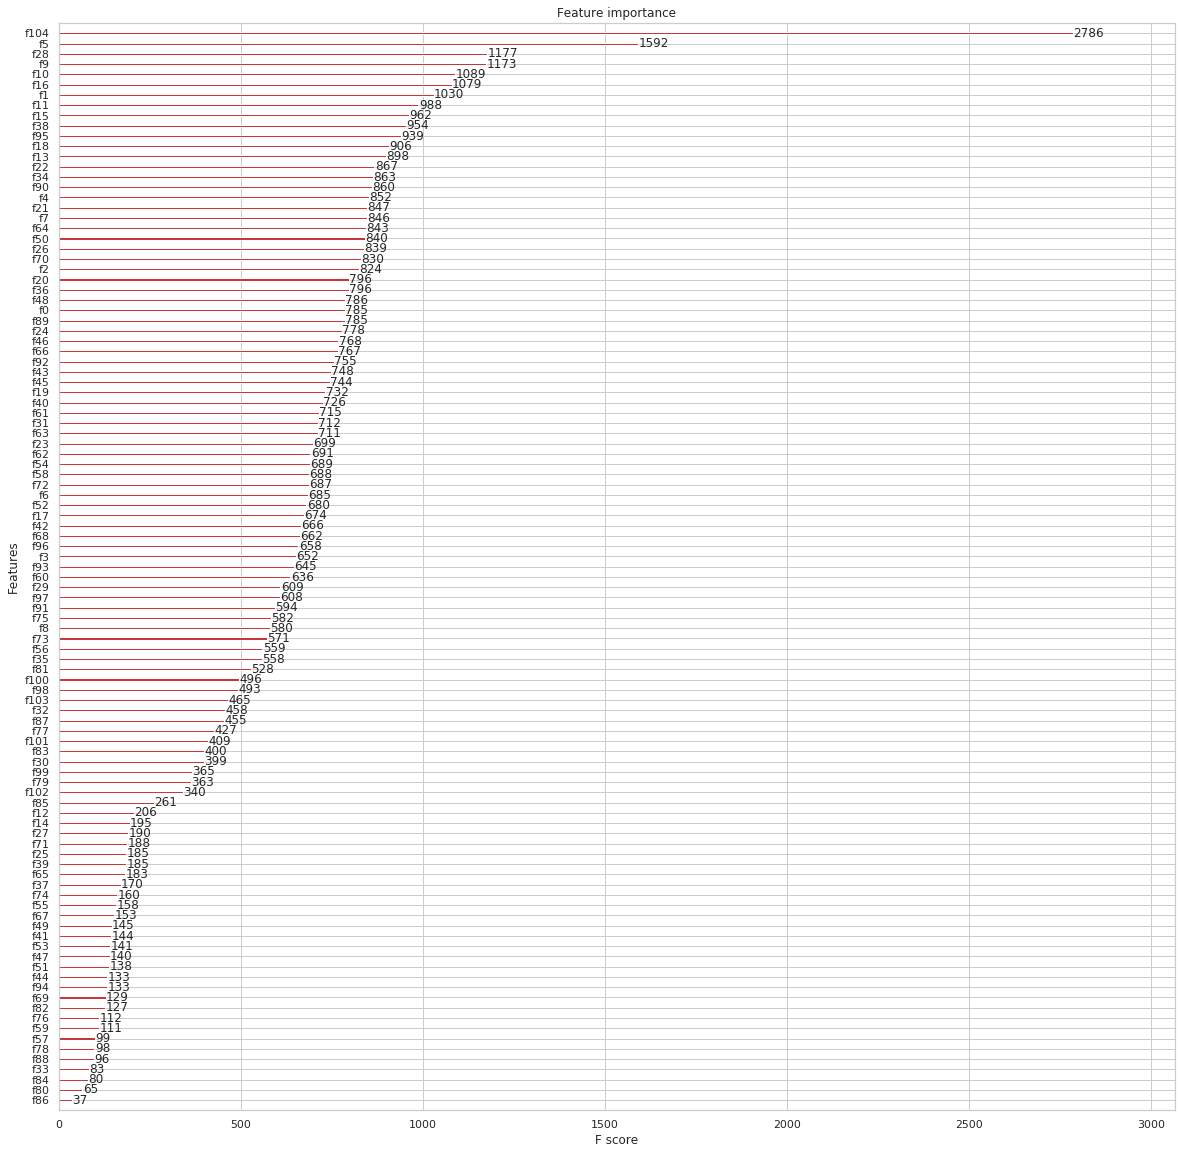

In [62]:
fimp = xgb.plot_importance(model_xgb)
fig = fimp.figure
fig.set_size_inches(20, 20)

In [63]:
# hist_plot(y_score, 'Predicted PPI')

Creating a residual histogram plot, a residual q-q plot, and a residuals vs. predicted values plot:

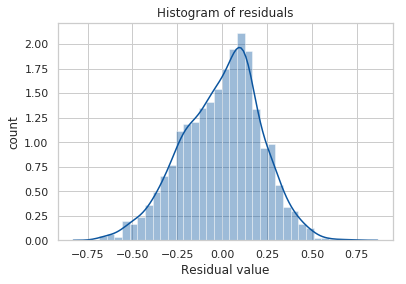

In [64]:
def hist_resids(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.set(style = 'whitegrid', palette='Blues_r')
    sns.distplot(resids)
    plt.title('Histogram of residuals')
    plt.xlabel('Residual value')
    plt.ylabel('count')
    
hist_resids(y_test, lgb_pred)    

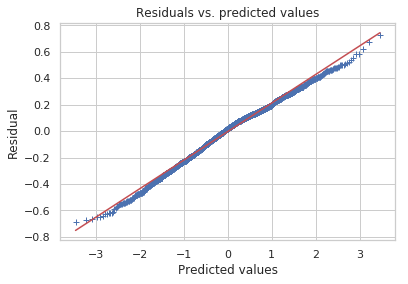

In [65]:
def resid_qq(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ss.probplot(resids.flatten(), plot = plt)
    ax.get_lines()[0].set_marker('+')
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')
    
resid_qq(y_test, lgb_pred)   

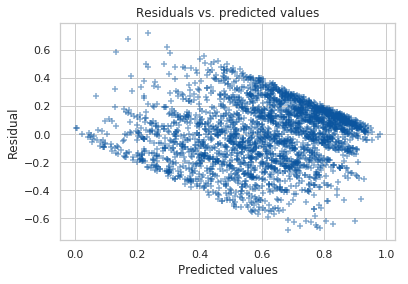

In [66]:
def resid_plot(y_test, y_score):
    ## first compute vector of residuals. 
    resids = np.subtract(y_test.reshape(-1,1), y_score.reshape(-1,1))
    ## now make the residual plots
    sns.regplot(y_score, resids, fit_reg=False, marker="+", scatter_kws={'alpha':0.5})
    plt.title('Residuals vs. predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residual')

resid_plot(y_test, lgb_pred) 

# External Test Data Preparation

A seperated file containing test data was provided by DrivenData for testing and submission. We prepare these test features the same way the train data was prepared in order to fit the model.

In [67]:
test_df = pd.read_csv('../input/test_values.csv')

Drop duplicates, uninformative features, and impute missing values:

In [68]:
test_df = test_df.drop_duplicates(keep = 'last')
test_df = test_df.drop_duplicates(subset = 'row_id', keep = 'last')

test_df.shape
test_df.drop('bank_interest_rate', axis = 1, inplace = True)
test_df.drop('mm_interest_rate', axis = 1, inplace = True)
test_df.drop('mfi_interest_rate', axis = 1, inplace = True)
test_df.drop('other_fsp_interest_rate', axis = 1, inplace = True)


test_df['education_level'].fillna(4, inplace=True)
test_df['share_hh_income_provided'].fillna(0, inplace=True)
# test_df.dropna(subset=['education_level'], inplace=True)
# test_df.dropna(subset=['share_hh_income_provided'], inplace=True)

test_df.isnull().sum()

row_id                                   0
country                                  0
is_urban                                 0
age                                      0
female                                   0
married                                  0
religion                                 0
relationship_to_hh_head                  0
education_level                          0
literacy                                 0
can_add                                  0
can_divide                               0
can_calc_percents                        0
can_calc_compounding                     0
employed_last_year                       0
employment_category_last_year            0
employment_type_last_year                0
share_hh_income_provided                 0
income_ag_livestock_last_year            0
income_friends_family_last_year          0
income_government_last_year              0
income_own_business_last_year            0
income_private_sector_last_year          0
income_publ

In [69]:
test_df.shape

(8400, 55)

In [70]:
# replace_boolean(test_df)
# test_df.dtypes

In [71]:
# test_df = test_df[test_df.relationship_to_hh_head != 'Unknown']
# test_df.shape

Feature engineering:

In [72]:
create_age_group(test_df)
test_df['religion'] = [religion_categories[x] for x in test_df['religion']]
test_df['num_shocks_last_year'] = [num_shocks_last_year_categories[x] for x in test_df['num_shocks_last_year']]
test_df['num_formal_institutions_last_year'] = [num_formal_institutions_last_year_categories[x] for x in test_df['num_formal_institutions_last_year']]
test_df['num_informal_institutions_last_year'] = [num_informal_institutions_last_year_categories[x] for x in test_df['num_informal_institutions_last_year']]
test_df['relationship_to_hh_head'] = [relationship_to_hh_head_categories[x] for x in test_df['relationship_to_hh_head']]

In [73]:
print(test_df['relationship_to_hh_head'].value_counts())

Head              3521
Spouse            2733
Son/Daughter      1466
Father/Mother      265
Other              233
Sister/Brother     182
Name: relationship_to_hh_head, dtype: int64


In [74]:
# test_df.loc[test_df.education_level.isnull(), :]

Onehotencode categorical features:

In [75]:
test_Features = encode_string(test_df['age_group'])
for col in features_cat_cols:
    test_temp = encode_string(test_df[col])
    test_Features = np.concatenate([test_Features, test_temp], axis = 1)

print(test_Features.shape)
print(test_Features[:2, :])


['x0_30 to 44' 'x0_45 to 59' 'x0_60 or Over' 'x0_Under 30']
['x0_A' 'x0_C' 'x0_D' 'x0_F' 'x0_G' 'x0_I' 'x0_J']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_N_Q' 'x0_O_P' 'x0_X']
['x0_Father/Mother' 'x0_Head' 'x0_Other' 'x0_Sister/Brother'
 'x0_Son/Daughter' 'x0_Spouse']
['x0_0.0' 'x0_1.0' 'x0_2.0' 'x0_3.0' 'x0_4.0']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_employed' 'x0_housewife_or_student' 'x0_other'
 'x0_retired_or_disabled' 'x0_unemployed']
['x0_irregular_seasonal' 'x0_not_working' 'x0_other' 'x0_salaried'
 'x0_self_employed']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_0' 'x0_1' 'x0_2']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False' 'x0_True']
['x0_False

Joining numeric features:

In [76]:
test_Features = np.concatenate([test_Features, np.array(test_df[features_num_cols])], axis = 1)
print(test_Features.shape)
print(test_Features[:2, :])

(8400, 143)
[[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0.
  1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1.
  0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 2. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0.
  1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.
  0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.
  0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [77]:
print(test_Features.shape)
test_Features_reduced = sel.fit_transform(test_Features)
print(test_Features_reduced.shape)

test_Features_reduced = selector.transform(test_Features_reduced)
print(test_Features_reduced.shape)

(8400, 143)
(8400, 132)
(8400, 105)


The whole training dataset was used to train the model, and the model is used to predict the separate test dataset:

In [78]:
nr.seed(265)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = None)
x_train = Features_reduced[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = test_Features_reduced
# y_test = np.ravel(Labels[indx[1]])

scaler = preprocessing.StandardScaler().fit(x_train[:,104:])
x_train[:,104:] = scaler.transform(x_train[:,104:])
x_test[:,104:] = scaler.transform(x_test[:,104:])

We first fit the selected models to the training data and fit them to the test data, then ensemeble the models with the assigned weights:

In [79]:
averaged_models.fit(x_train, y_train)
avg_pred = averaged_models.predict(x_test)
# model_xgb.fit(x_train, y_train)
# xgb_pred = model_xgb.predict(x_test)
model_lgb.fit(x_train, y_train)
lgb_pred = model_lgb.predict(x_test)
ensemble = avg_pred*0.55 + lgb_pred*0.45

It turned out that I achieved my highest score (0.4213) by submitting predictions using the LGB model, instead of the ensembled / averaged model. The discrepancy between the r2 score (0.4690) for the local test data and the external test data might be due to overfitting.

Create the final submission file:

In [80]:
test_id = test_df['row_id']
sub = pd.DataFrame({ 'row_id': test_id,
                            'poverty_probability': lgb_pred })
sub.to_csv('prediction_result_lgb_3.csv', index=False)